In [1]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount("/MyDrive")

Mounted at /MyDrive


In [3]:
import os
for dirpath, _, filename in os.walk("/MyDrive/MyDrive/telecom"):
    for name in filename:
        print(os.path.join(dirpath, name))

/MyDrive/MyDrive/telecom/11-01-16-34-39-1730468079.csv
/MyDrive/MyDrive/telecom/11-01-17-34-39-1730471679.csv
/MyDrive/MyDrive/telecom/11-01-20-34-39-1730482479.csv
/MyDrive/MyDrive/telecom/11-01-21-34-39-1730486079.csv
/MyDrive/MyDrive/telecom/11-01-22-34-39-1730489679.csv
/MyDrive/MyDrive/telecom/vae_weights_final.pth
/MyDrive/MyDrive/telecom/vae_weights_1.pth
/MyDrive/MyDrive/telecom/opendata.ipynb
/MyDrive/MyDrive/telecom/photo/Снимок экрана 2025-03-17 154354.png


In [4]:
!ls /MyDrive/MyDrive/telecom

11-01-16-34-39-1730468079.csv  opendata.ipynb
11-01-17-34-39-1730471679.csv  photo
11-01-20-34-39-1730482479.csv  vae_weights_1.pth
11-01-21-34-39-1730486079.csv  vae_weights_final.pth
11-01-22-34-39-1730489679.csv


In [5]:
data = pd.read_csv("/MyDrive/MyDrive/telecom/11-01-16-34-39-1730468079.csv")
data

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,185.7.214.20,158.250.17.140,TCP,60,53396 > 6547 [SYN] Seq=0 Win=1025 Len=0 MSS=...
1,2,0.012582,157.15.202.15,158.250.17.181,TCP,60,55501 > 30553 [SYN] Seq=0 Win=1024 Len=0
2,3,0.020753,83.222.190.246,158.250.17.240,TCP,60,56806 > 11944 [SYN] Seq=0 Win=1024 Len=0
3,4,0.023914,83.222.190.246,158.250.17.184,TCP,60,56806 > 14826 [SYN] Seq=0 Win=1024 Len=0
4,5,0.045710,213.87.130.79,188.44.42.233,WireGuard,122,"Transport Data, receiver=0x7B4BBC8A, counter=3..."
...,...,...,...,...,...,...,...
1375908,1375909,3599.923643,172.21.253.120,172.20.253.42,TLSv1.2,345,Application Data[Packet size limited during ca...
1375909,1375910,3599.923846,172.20.253.42,172.21.253.120,TLSv1.2,473,Application Data[Packet size limited during ca...
1375910,1375911,3599.924306,210.89.45.84,158.250.17.30,TCP,60,55533 > 35293 [SYN] Seq=0 Win=1024 Len=0
1375911,1375912,3599.928318,45.142.212.229,158.250.17.159,TCP,60,42562 > 2064 [SYN] Seq=0 Win=1025 Len=0 MSS=...


In [ ]:
np.diff(data['Time'])

array([0.012582, 0.008171, 0.003161, ..., 0.00046 , 0.004012, 0.00021 ])

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

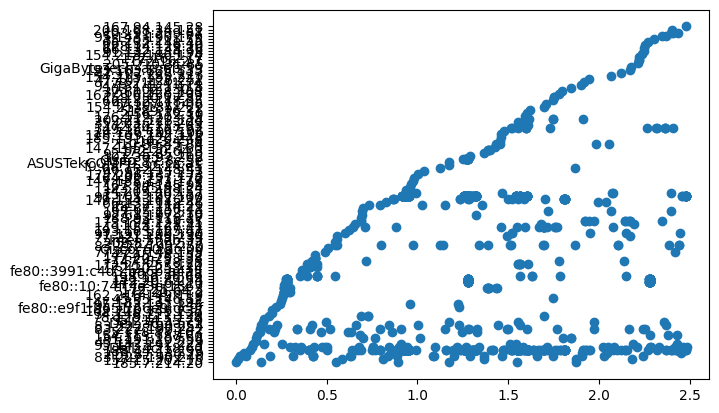

In [ ]:
plt.scatter(data.loc[:1000, "Time"], data.loc[:1000, "Source"])
plt.show()

In [ ]:
model = KMeans(n_clusters=3)
data_size = 1000
train = data.loc[:data_size, ["Source", "Destination", "Time", "Length", "Protocol"]]


# Заменил ip на числа, чтобы было проще обрабатывать


In [ ]:
sourceId = dict()
destId = dict()
protocol = dict()
count = 0
for ip in train.loc[:data_size, "Source"].unique():
    sourceId[ip] = count
    count += 1
count2 = 0
for ip in train.loc[:data_size, "Destination"].unique():
    destId[ip] = count2
    count2 += 1
count3 = 0
for ip in train.loc[:data_size, "Protocol"].unique():
    protocol[ip] = count3
    count3 += 1
# sourceId
# destId
# protocol

In [ ]:
train = train.replace({"Source" : sourceId, "Destination": destId, "Protocol": protocol})
d_train = train.copy()

<ipython-input-10-f87fbd21d063>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train = train.replace({"Source" : sourceId, "Destination": destId, "Protocol": protocol})


In [ ]:
model.fit(train)

KMeans(n_clusters=3)

In [ ]:
labels = model.labels_
centroids = model.cluster_centers_

In [ ]:
labels

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

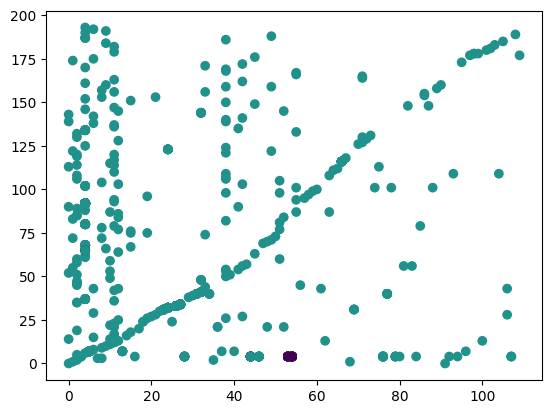

In [ ]:
plt.scatter(train.loc[:data_size, "Source"], train.loc[:data_size, "Destination"], c=labels)
plt.show()

<Axes: xlabel='Length'>

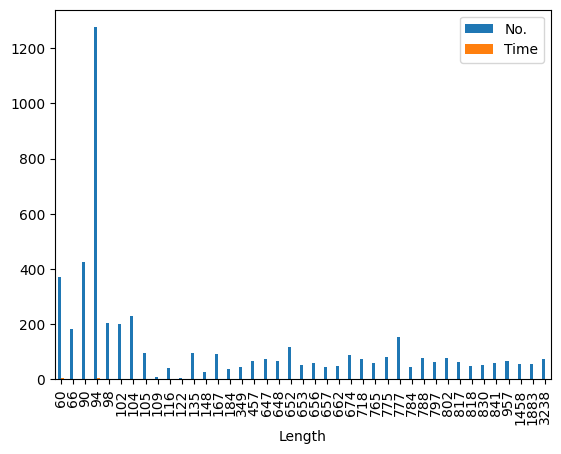

In [ ]:
data.iloc[:100, :].groupby("Length").sum().plot(kind="bar")

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim.adam import Adam
from torch.utils.data import Dataset, DataLoader, random_split

file = d_train

class Dataset(Dataset):

    def __init__(self, file):
        self.dataframe = file.loc[:, ["Source", "Destination", "Protocol", "Length"]].dropna()
        self.features = self.dataframe.values
        self.mean = self.features.mean(axis=0)
        self.std = self.features.std(axis=0)
        self.features = (self.features - self.mean) / self.std

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        features = torch.tensor(self.features[idx], dtype=torch.float32).to(device)
        return features

dataset = Dataset(file)


In [ ]:
batch_size = 64
input_dim = 2

train_dataset, test_dataset = random_split(dataset, [0.8,0.2])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class VAE(nn.Module):

    def __init__(self, input_dim=4, hidden_dim=10, latent_dim=3, device=device):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_dim, latent_dim),
        nn.LeakyReLU(0.2)
        )

        self.mean_layer = nn.Linear(latent_dim, 1)
        self.logvar_layer = nn.Linear(latent_dim, 1)

        self.decoder = nn.Sequential(
        nn.Linear(1, latent_dim),
        nn.LeakyReLU(0.2),
        nn.Linear(latent_dim, hidden_dim),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_dim, input_dim)
        )

    def encode(self, x):
        x = self.encoder(x)
        mean, log_var = self.mean_layer(x), self.logvar_layer(x)
        return mean, log_var

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, log_var)
        x_hat = self.decode(z)
        return x_hat, mean, log_var

    def reconstruction(mean, log_var):
        z = self.reparameterization(mean, log_var)
        x_hat = self.decode(z)
        return x_hat




In [ ]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x)
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD

model = VAE().to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

KeyboardInterrupt: 

In [ ]:
def train(model, optimizer, epochs, device):

    model.train()

    for epoch in range(epochs):
        overall_loss = 0

        for batch_idx, x in enumerate(train_dataloader):
            x = x.to(device)

            optimizer.zero_grad()
            x_hat, mean, log_var = model(x)

            loss = loss_function(x, x_hat, mean, log_var)
            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx+1))

    return overall_loss


train(model, optimizer, epochs=5, device=device)


In [ ]:
def predict(model):

    model.eval()
    dataset_size = 0

    with torch.no_grad():
        overall_loss = 0
        all_mean = None
        all_log_var = None

        for batch_idx, x in enumerate(test_dataloader):

            x_hat, mean, log_var = model(x)

            loss = loss_function(x, x_hat, mean, log_var)

            if all_mean is not None:
                all_mean = torch.cat((all_mean, mean))
                all_log_var = torch.cat((all_log_var, log_var))
            else:
                all_mean = mean
                all_log_var = log_var

            overall_loss += loss.item()

            size_batch = x.element_size() * x.numel()
            dataset_size += size_batch

        compressed_size = (all_mean.element_size() * all_mean.numel()) + (all_log_var.element_size() * all_log_var.numel())

        print("\tAverage Loss: ", overall_loss/(batch_idx+1))
        print(f"\tDataset Size: {dataset_size} \n\tCompressed Size: {compressed_size}")
        print("\tCompression Ratio: ", compressed_size/dataset_size)

        return all_mean, all_log_var


mean, var = predict(model)


 # Агрегация пакетов в потоки по (Source, Destination, Protocol, Source Port, Destination Port)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from itertools import product


def create_flows(df, timeout=60):
    df['Time'] = pd.to_numeric(df['Time'])
    df = df.sort_values(by='Time')

    df['Flow_ID'] = (df.groupby(['Source', 'Destination', 'Protocol'])['Time']
                     .diff() > timeout).cumsum()

    flows = df.groupby(['Source', 'Destination', 'Protocol', 'Flow_ID']).agg(
        packet_count=('Time', 'count'),
        duration=('Time', lambda x: x.max() - x.min()),
        mean_packet_size=('Length', 'mean'),
        std_packet_size=('Length', 'std'),
        min_packet_size=('Length', 'min'),
        max_packet_size=('Length', 'max'),
    ).reset_index()

    flows.fillna(0, inplace=True)
    return flows

flows_df = create_flows(data)

scaler = StandardScaler()
X = scaler.fit_transform(flows_df[['packet_count', 'duration', 'mean_packet_size',
                                   'std_packet_size', 'min_packet_size', 'max_packet_size']])


In [ ]:
X.shape
X_part = X[:20_000]
X_part.shape, X.shape

((20000, 6), (754255, 6))

In [ ]:
# X_part
flows_df

,Source,Destination,Protocol,Flow_ID,packet_count,duration,mean_packet_size,std_packet_size,min_packet_size,max_packet_size
0,0.0.0.0,224.0.0.1,IGMPv2,16,1,0.0,60.0,0.0,60,60
1,0.0.0.0,224.0.0.1,IGMPv2,253,1,0.0,60.0,0.0,60,60
2,0.0.0.0,224.0.0.1,IGMPv2,19566,1,0.0,60.0,0.0,60,60
3,0.0.0.0,224.0.0.1,IGMPv2,54078,1,0.0,60.0,0.0,60,60
4,0.0.0.0,224.0.0.1,IGMPv2,93473,1,0.0,60.0,0.0,60,60
...,...,...,...,...,...,...,...,...,...,...
754250,fe80::ff5c:7475:dd70:9bcb,ff02::fb,MDNS,45028,1,0.0,202.0,0.0,202,202
754251,fe80::ff5c:7475:dd70:9bcb,ff02::fb,MDNS,50702,1,0.0,260.0,0.0,260,260
754252,fe80::ff5c:7475:dd70:9bcb,ff02::fb,MDNS,50751,1,0.0,102.0,0.0,102,102
754253,fe80::ff5c:7475:dd70:9bcb,ff02::fb,MDNS,50812,1,0.0,102.0,0.0,102,102


In [ ]:
data_for_clustering = []

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np


class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc21 = nn.Linear(256, latent_dim)  # Среднее распределения
        self.fc22 = nn.Linear(256, latent_dim)  # Логарифм стандартного отклонения
        self.fc3 = nn.Linear(latent_dim, 256)
        self.fc4 = nn.Linear(256, input_dim)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        result_forward_data = mu + eps*std
        data_for_clustering.append(result_forward_data)
        return result_forward_data

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return self.fc4(h3)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, input_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def loss_function(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x.view(-1, input_dim), reduction='sum')
    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE + KL


X_part = torch.tensor(X_part, dtype=torch.float32)


train_data, test_data = train_test_split(X_part, test_size=0.2, random_state=42)

input_dim = X_part.shape[1]
latent_dim = 2
vae = VAE(input_dim, latent_dim)

optimizer = optim.Adam(vae.parameters(), lr=1e-4)

epochs = 20
for epoch in range(epochs):
    vae.train()
    train_loss = 0
    for data in train_data:
        data = data.unsqueeze(0)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f"Epoch {epoch+1}, Training loss: {train_loss / len(train_data)}")

vae.eval()
test_loss = 0
with torch.no_grad():
    for data in test_data:
        data = data.unsqueeze(0)
        recon_batch, mu, logvar = vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        test_loss += loss.item()

print(f"Test loss: {test_loss / len(test_data)}")


<ipython-input-31-a82b0a04b2f8>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_part = torch.tensor(X_part, dtype=torch.float32)


Epoch 1, Training loss: 2.891848664990626
Epoch 2, Training loss: 2.1824097653273493
Epoch 3, Training loss: 1.9061221151519567
Epoch 4, Training loss: 1.6748860721988603
Epoch 5, Training loss: 1.7139162226431073
Epoch 6, Training loss: 1.5286742791067809
Epoch 7, Training loss: 1.5056846142392606
Epoch 8, Training loss: 1.4688016753895208
Epoch 9, Training loss: 1.446806707719341
Epoch 10, Training loss: 1.4204069399684667
Epoch 11, Training loss: 1.4115723777068778
Epoch 12, Training loss: 1.4226338535482064
Epoch 13, Training loss: 1.3979479812569917
Epoch 14, Training loss: 1.3821927738785744
Epoch 15, Training loss: 1.3736864349916578
Epoch 16, Training loss: 1.3683545062430202
Epoch 17, Training loss: 1.3584470578841865
Epoch 18, Training loss: 1.3810229282910005
Epoch 19, Training loss: 1.3487738014580681
Epoch 20, Training loss: 1.3698675253158434
Test loss: 1.3189001246988774


In [ ]:
data_for_clustering[0][0][0]

Cluster 0: 98249 points
Cluster 1: 177324 points
Cluster 2: 194578 points


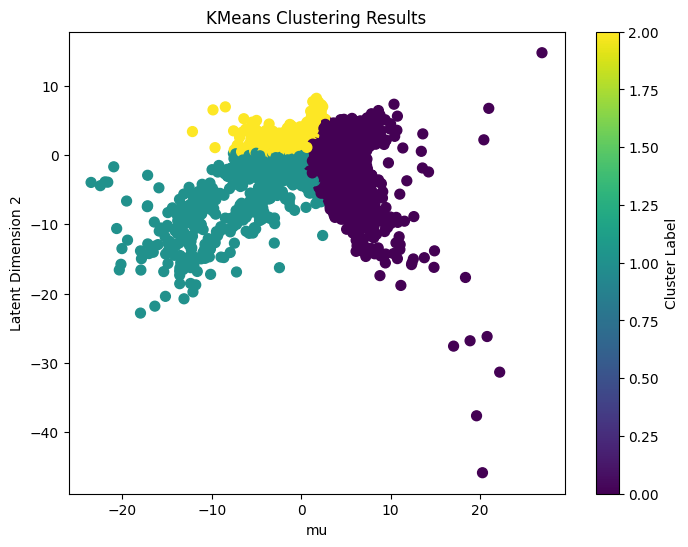

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
samples = np.array([elem.detach().numpy().flatten() for elem in data_for_clustering])
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(samples)
labels = kmeans.labels_
cluster_counts = np.bincount(labels)

for i, count in enumerate(cluster_counts):
    print(f"Cluster {i}: {count} points")
plt.figure(figsize=(8, 6))
plt.scatter(samples[:, 0], samples[:, 1], c=labels, cmap='viridis', s=50)

plt.title("KMeans Clustering Results")
plt.xlabel("mu")
plt.ylabel("Latent Dimension 2")

plt.colorbar(label='Cluster Label')
plt.show()


In [ ]:
save_path = '/MyDrive/MyDrive/telecom/vae_weights_1.pth'
torch.save(vae.state_dict(), save_path)

# Для сравнения аномальных данных с обычными

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np

def reconstruction_error(x, recon_x):
    return F.mse_loss(recon_x, x, reduction='none').sum(dim=1)

def anomaly_detection(vae, data, threshold=None):
    vae.eval()
    errors = []
    with torch.no_grad():
        for sample in data:
            sample = sample.unsqueeze(0)
            recon_batch, mu, logvar = vae(sample)
            error = reconstruction_error(sample, recon_batch)
            errors.append(error.item())

    errors = np.array(errors)

    mean_error = np.mean(errors)
    std_error = np.std(errors)
    threshold = mean_error + 3 * std_error

    anomalies = errors > threshold
    return anomalies, errors, threshold

anomalies, errors, threshold = anomaly_detection(vae, test_data)

anomalous_indices = np.where(anomalies)[0]

print(f"{len(anomalous_indices)} аномалий в {len(test_data)} сэмплах")
print(f"Порог: {threshold}")
print(f"Количество аномалий: {len(anomalous_indices)}")

39 аномалий в 2000 сэмплах
Порог: 6.42782715008418
Количество аномалий: 39


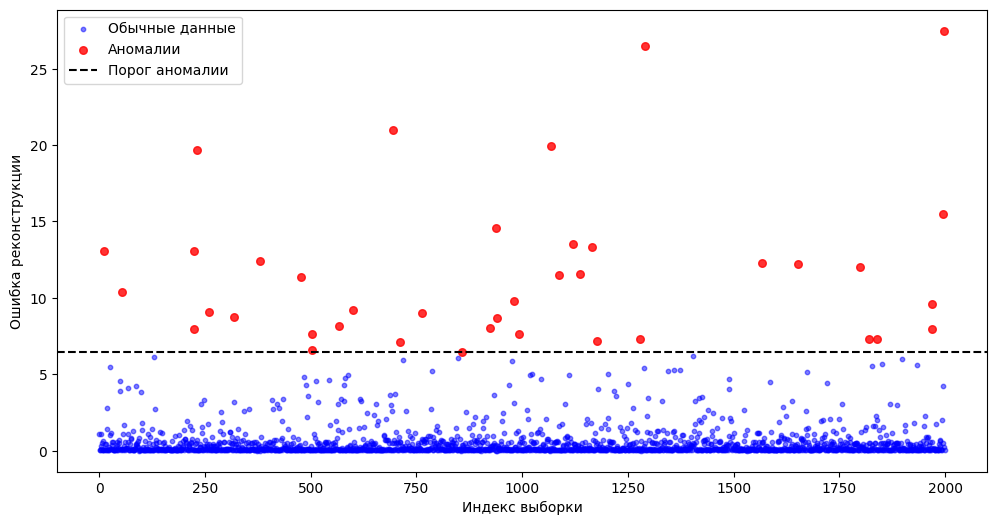

In [ ]:
normal_indices = np.setdiff1d(np.arange(len(errors)), anomalous_indices)

normal_errors = errors[normal_indices]
anomalous_errors = errors[anomalous_indices]

plt.figure(figsize=(12, 6))
plt.scatter(normal_indices, normal_errors, color='blue', label='Обычные данные', alpha=0.5, s=10)
plt.scatter(anomalous_indices, anomalous_errors, color='red', label='Аномалии', alpha=0.8, s=30)

plt.axhline(y=threshold, color='black', linestyle='--', label='Порог аномалии')
plt.xlabel('Индекс выборки')
plt.ylabel('Ошибка реконструкции')
plt.legend()
plt.show()


In [ ]:
normal_indices = np.where(~anomalies)[0]

k = np.random.randint(1, 10)
n = np.random.randint(1, 100)
normal_samples = flows_df.iloc[normal_indices[n:n+20]]
anomalous_samples = flows_df.iloc[anomalous_indices[k: k+20]]

print("20 обычных данных:")
print(normal_samples.drop(columns=['is_anomaly']))

print("\n\n\n20 аномальных данных:\n\n")
print(anomalous_samples.drop(columns=['is_anomaly']))


20 обычных данных:
     Source Destination Protocol  Flow_ID  packet_count  duration  \
58  0.0.0.0   224.0.0.1   IGMPv3    50572             1       0.0   
59  0.0.0.0   224.0.0.1   IGMPv3    52330             1       0.0   
60  0.0.0.0   224.0.0.1   IGMPv3    53013             1       0.0   
61  0.0.0.0   224.0.0.1   IGMPv3    54010             1       0.0   
62  0.0.0.0   224.0.0.1   IGMPv3    55278             1       0.0   
63  0.0.0.0   224.0.0.1   IGMPv3    56953             1       0.0   
64  0.0.0.0   224.0.0.1   IGMPv3    57792             1       0.0   
65  0.0.0.0   224.0.0.1   IGMPv3    58613             1       0.0   
66  0.0.0.0   224.0.0.1   IGMPv3    63202             1       0.0   
67  0.0.0.0   224.0.0.1   IGMPv3    68923             1       0.0   
68  0.0.0.0   224.0.0.1   IGMPv3    71536             1       0.0   
69  0.0.0.0   224.0.0.1   IGMPv3    71737             1       0.0   
70  0.0.0.0   224.0.0.1   IGMPv3    73729             1       0.0   
71  0.0.0.0   2

In [ ]:
normal_samples = flows_df.iloc[normal_indices[:20]]
anomalous_samples = flows_df.iloc[anomalous_indices[:20]]

print("20 обычных данных:")
print(normal_samples.drop(columns=['is_anomaly']))

print("\n\n\n20 аномальных данных:\n\n")
print(anomalous_samples.drop(columns=['is_anomaly']))

20 обычных данных:
     Source Destination Protocol  Flow_ID  packet_count  duration  \
0   0.0.0.0   224.0.0.1   IGMPv2       16             1       0.0   
1   0.0.0.0   224.0.0.1   IGMPv2      253             1       0.0   
2   0.0.0.0   224.0.0.1   IGMPv2    19566             1       0.0   
3   0.0.0.0   224.0.0.1   IGMPv2    54078             1       0.0   
4   0.0.0.0   224.0.0.1   IGMPv2    93473             1       0.0   
5   0.0.0.0   224.0.0.1   IGMPv2    94894             1       0.0   
6   0.0.0.0   224.0.0.1   IGMPv2   102894             1       0.0   
7   0.0.0.0   224.0.0.1   IGMPv2   103003             1       0.0   
8   0.0.0.0   224.0.0.1   IGMPv3        0             1       0.0   
9   0.0.0.0   224.0.0.1   IGMPv3      533             1       0.0   
10  0.0.0.0   224.0.0.1   IGMPv3     1976             1       0.0   
12  0.0.0.0   224.0.0.1   IGMPv3     3096             1       0.0   
13  0.0.0.0   224.0.0.1   IGMPv3     3428             1       0.0   
14  0.0.0.0   2

    Source Destination Protocol  Flow_ID  packet_count  duration  \
0  0.0.0.0   224.0.0.1   IGMPv2       16             1       0.0   
1  0.0.0.0   224.0.0.1   IGMPv2      253             1       0.0   
2  0.0.0.0   224.0.0.1   IGMPv2    19566             1       0.0   
3  0.0.0.0   224.0.0.1   IGMPv2    54078             1       0.0   
4  0.0.0.0   224.0.0.1   IGMPv2    93473             1       0.0   

   mean_packet_size  std_packet_size  min_packet_size  max_packet_size  \
0              60.0              0.0               60               60   
1              60.0              0.0               60               60   
2              60.0              0.0               60               60   
3              60.0              0.0               60               60   
4              60.0              0.0               60               60   

   Cluster_Label  
0              0  
1              0  
2              0  
3              0  
4              0  


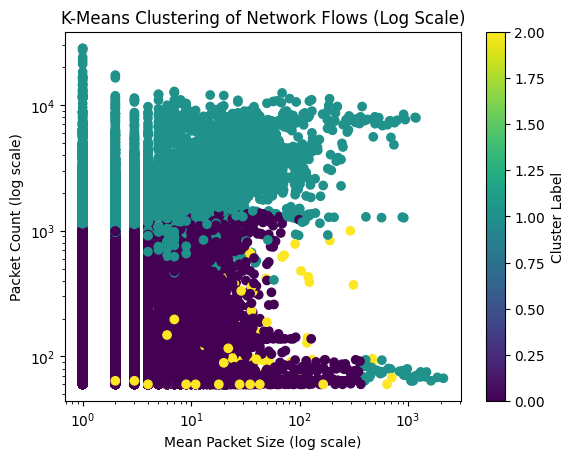

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

data = pd.DataFrame(data)

flow_data = create_flows(data)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(flow_data[['packet_count', 'duration', 'mean_packet_size',
                                           'std_packet_size', 'min_packet_size', 'max_packet_size']])

n_clusters = 3
kmeans_model = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_model.fit(X_scaled)

cluster_labels = kmeans_model.labels_

flow_data['Cluster_Label'] = cluster_labels

print(flow_data.head())

plt.scatter(flow_data['packet_count'], flow_data['mean_packet_size'] , c=flow_data['Cluster_Label'], cmap='viridis')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Mean Packet Size (log scale)')
plt.ylabel('Packet Count (log scale)')
plt.title('K-Means Clustering of Network Flows (Log Scale)')
plt.colorbar(label='Cluster Label')
plt.show()


Вероятность экстремальных значений для packet_count: 0.4962
Вероятность экстремальных значений для duration: 0.5006
Вероятность экстремальных значений для mean_packet_size: 0.4979
Вероятность экстремальных значений для max_packet_size: 0.4920


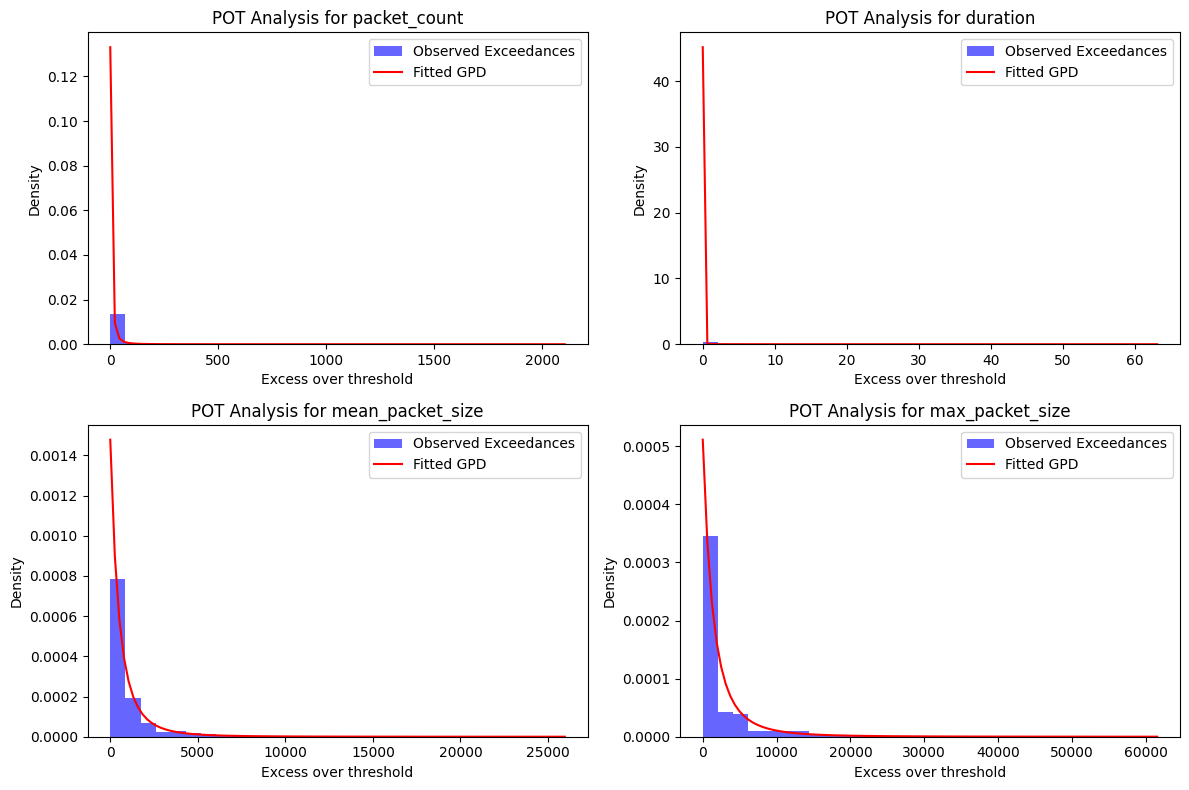

In [ ]:
import scipy.stats as ss
import matplotlib.pyplot as plt

features = ['packet_count', 'duration', 'mean_packet_size', 'max_packet_size']
threshold_percentile = 99

plt.figure(figsize=(12, 8))

for i, feature in enumerate(features, 1):
    data = flows_df[feature]

    threshold = np.percentile(data, threshold_percentile)

    excesses = data[data > threshold] - threshold

    if len(excesses) == 0:
        print(f"Для {feature} нет значений выше {threshold_percentile}-го процентиля.")
        continue

    shape, loc, scale = ss.genpareto.fit(excesses)

    x = np.linspace(excesses.min(), excesses.max(), 100)
    pdf = ss.genpareto.pdf(x, shape, loc=loc, scale=scale)

    plt.subplot(2, 2, i)
    plt.hist(excesses, bins=30, density=True, alpha=0.6, color='b', label="Observed Exceedances")
    plt.plot(x, pdf, 'r-', label="Fitted GPD")
    plt.xlabel("Excess over threshold")
    plt.ylabel("Density")
    plt.title(f"POT Analysis for {feature}")
    plt.legend()

    extreme_prob = 1 - ss.genpareto.cdf(excesses, shape, loc=loc, scale=scale)
    print(f"Вероятность экстремальных значений для {feature}: {extreme_prob.mean():.4f}")

plt.tight_layout()
plt.show()


In [ ]:
flows_df['extreme_packet_count'] = flows_df['packet_count'] > np.percentile(flows_df['packet_count'], 99)
flows_df['extreme_duration'] = flows_df['duration'] > np.percentile(flows_df['duration'], 99)
flows_df['extreme_mean_packet_size'] = flows_df['mean_packet_size'] > np.percentile(flows_df['mean_packet_size'], 99)

anomalies = flows_df[flows_df[['extreme_packet_count', 'extreme_duration', 'extreme_mean_packet_size']].any(axis=1)]
print("Найдено аномальных потоков:", len(anomalies))
anomalies.head()


Найдено аномальных потоков: 19879


,Source,Destination,Protocol,Flow_ID,packet_count,duration,mean_packet_size,std_packet_size,min_packet_size,max_packet_size,extreme_packet_count,extreme_duration,extreme_mean_packet_size
255,1.0.0.1,188.44.42.233,DNS,0,22,48.485465,187.363636,174.364027,96,804,True,True,False
256,1.0.0.1,188.44.42.233,DNS,1,6,0.297115,364.833333,129.783538,142,489,False,True,False
257,1.0.0.1,188.44.42.233,DNS,2,3,0.272500,292.333333,275.601766,117,610,False,True,False
268,1.0.0.1,188.44.42.233,DNS,238,6,0.195320,209.833333,200.101391,96,613,False,True,False
270,1.0.0.1,188.44.42.233,DNS,240,39,0.318404,321.435897,321.407005,124,1127,True,True,False


In [ ]:
X_res = X[:30000, :]
# flows_df_res = flows_df.iloc[:10000, :]

In [ ]:
flows_df_res

,Source,Destination,Protocol,Flow_ID,packet_count,duration,mean_packet_size,std_packet_size,min_packet_size,max_packet_size
0,0.0.0.0,224.0.0.1,IGMPv2,16,1,0.000000,60.0,0.000000,60,60
1,0.0.0.0,224.0.0.1,IGMPv2,253,1,0.000000,60.0,0.000000,60,60
2,0.0.0.0,224.0.0.1,IGMPv2,19566,1,0.000000,60.0,0.000000,60,60
3,0.0.0.0,224.0.0.1,IGMPv2,54078,1,0.000000,60.0,0.000000,60,60
4,0.0.0.0,224.0.0.1,IGMPv2,93473,1,0.000000,60.0,0.000000,60,60
...,...,...,...,...,...,...,...,...,...,...
9995,10.16.248.21,10.3.128.15,TCP,94567,2,0.001415,70.0,5.656854,66,74
9996,10.16.248.21,10.3.128.15,TCP,94571,2,0.010535,66.0,0.000000,66,66
9997,10.16.248.21,10.3.128.15,TCP,94637,2,0.001712,70.0,5.656854,66,74
9998,10.16.248.21,10.3.128.15,TCP,94638,1,0.000000,66.0,0.000000,66,66


In [ ]:
from scipy.stats import genpareto, expon
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

#PoT с восходящим и нисходящим методами

In [ ]:
names = ['packet_count', 'duration', 'mean_packet_size',
                                   'std_packet_size', 'min_packet_size', 'max_packet_size']

0.06632959631277457 0.0


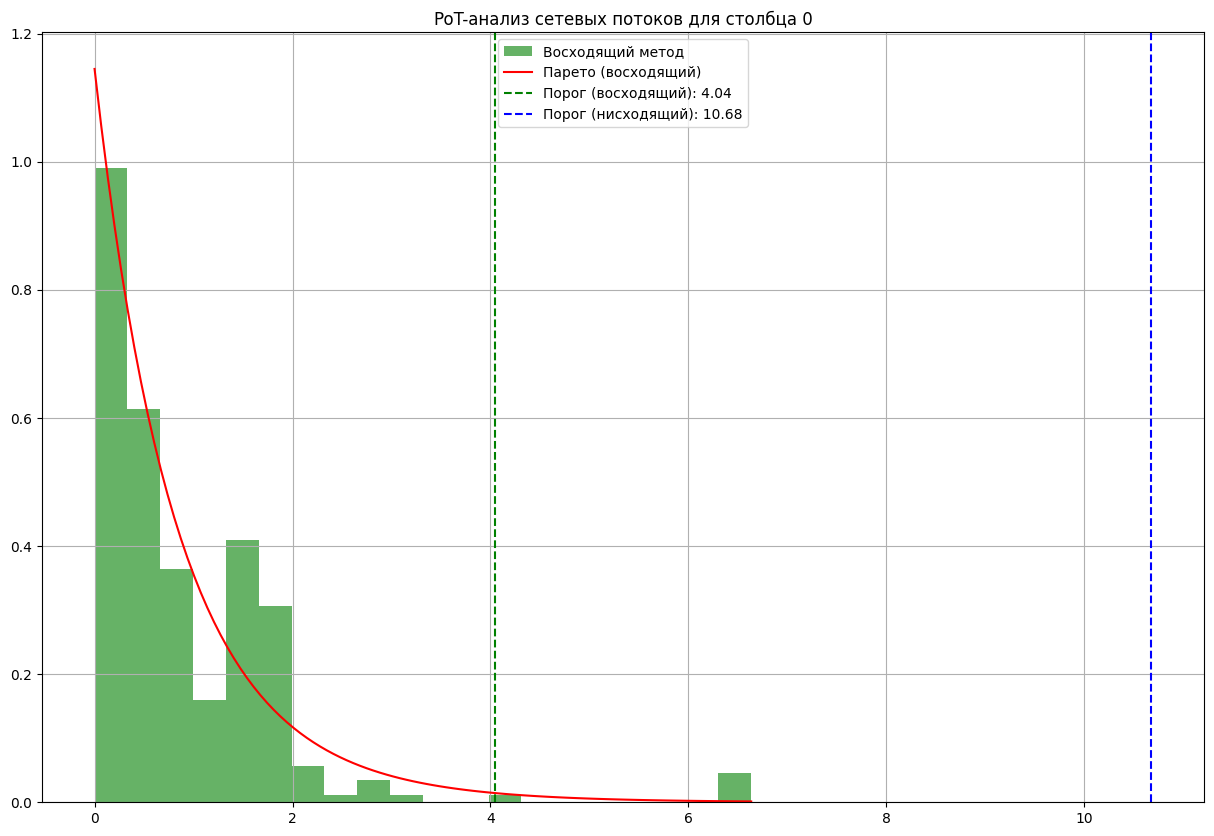

Столбец packet_count:
Порог (восходящий): 4.04
Порог (нисходящий): 10.68
p-value для восходящего метода с распределением Парето: 0.04386
p-value для нисходящего метода с распределением Парето: 0.00000

0.0 0.0


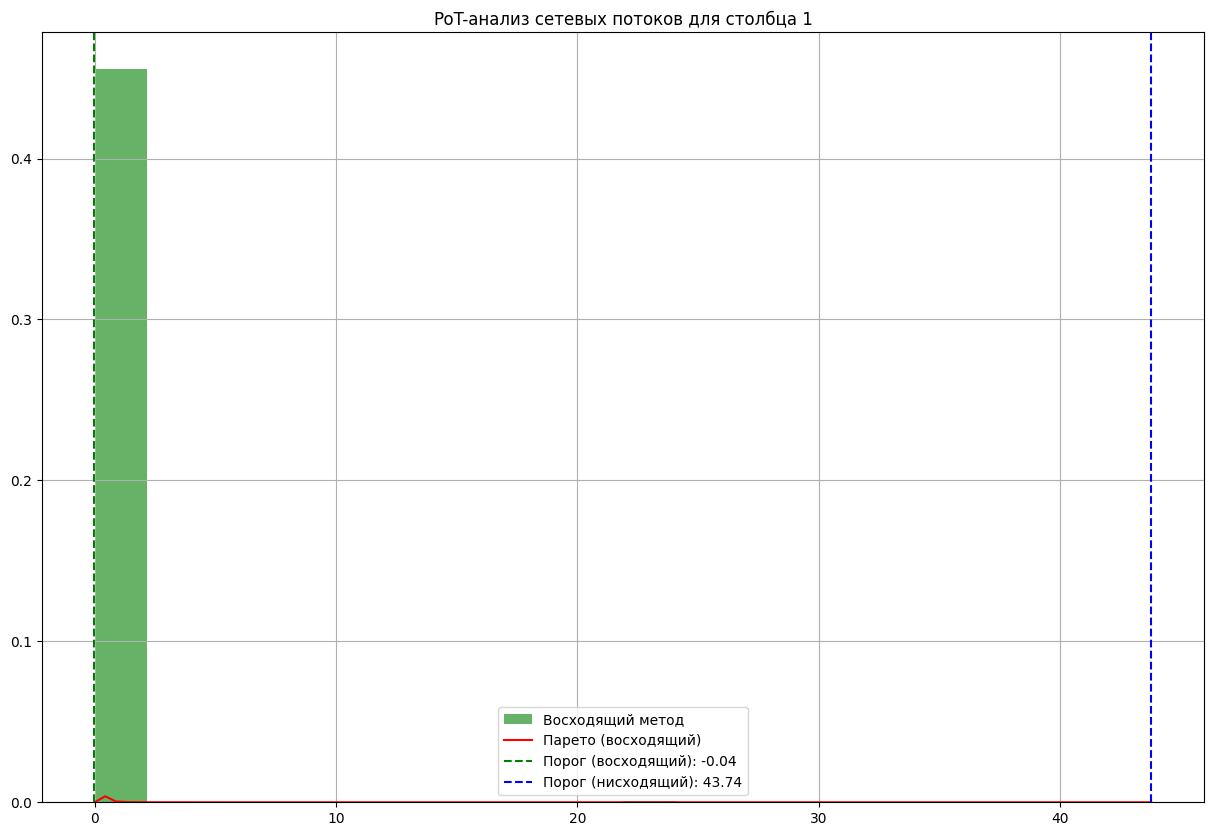

Столбец duration:
Порог (восходящий): -0.04
Порог (нисходящий): 43.74
p-value для восходящего метода с распределением Парето: 0.00000
p-value для нисходящего метода с распределением Парето: 0.00000

0.14298553896512045 0.0


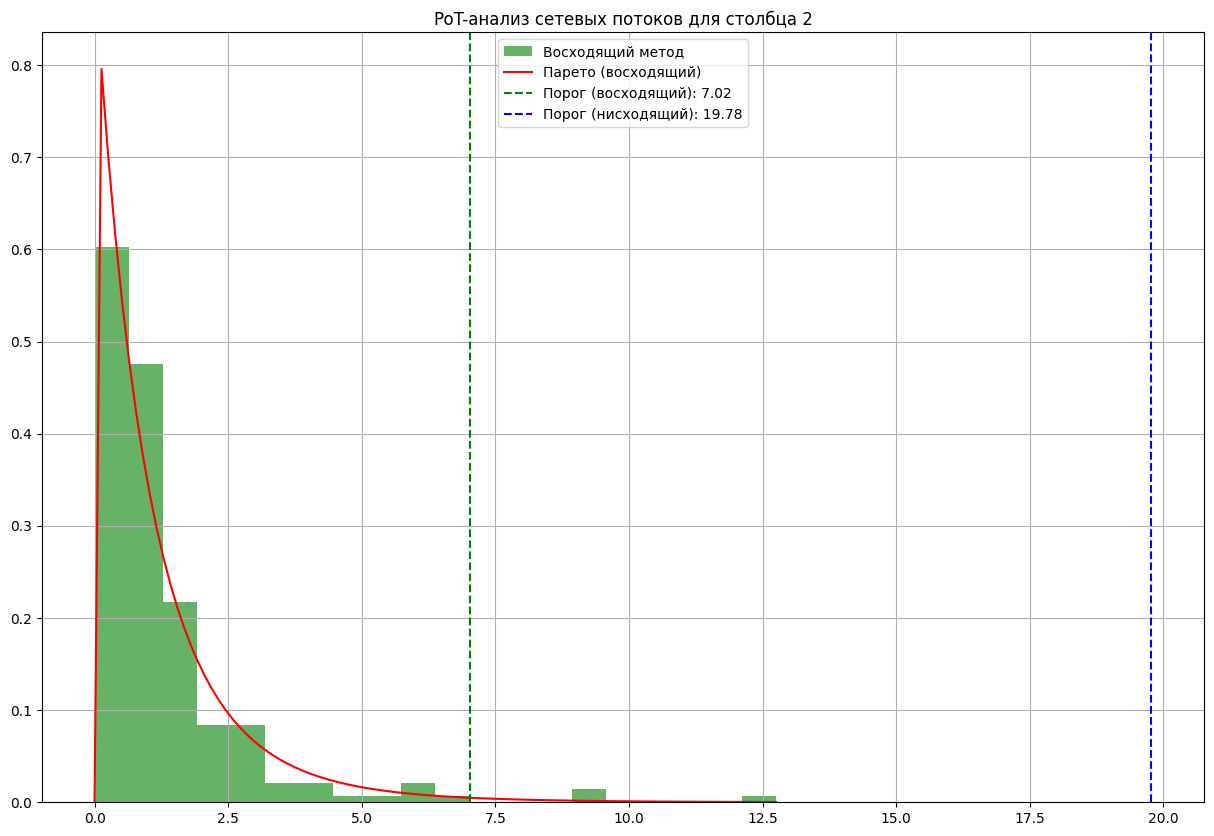

Столбец mean_packet_size:
Порог (восходящий): 7.02
Порог (нисходящий): 19.78
p-value для восходящего метода с распределением Парето: 0.10910
p-value для нисходящего метода с распределением Парето: 0.00000

0.07675106988260307 0.0


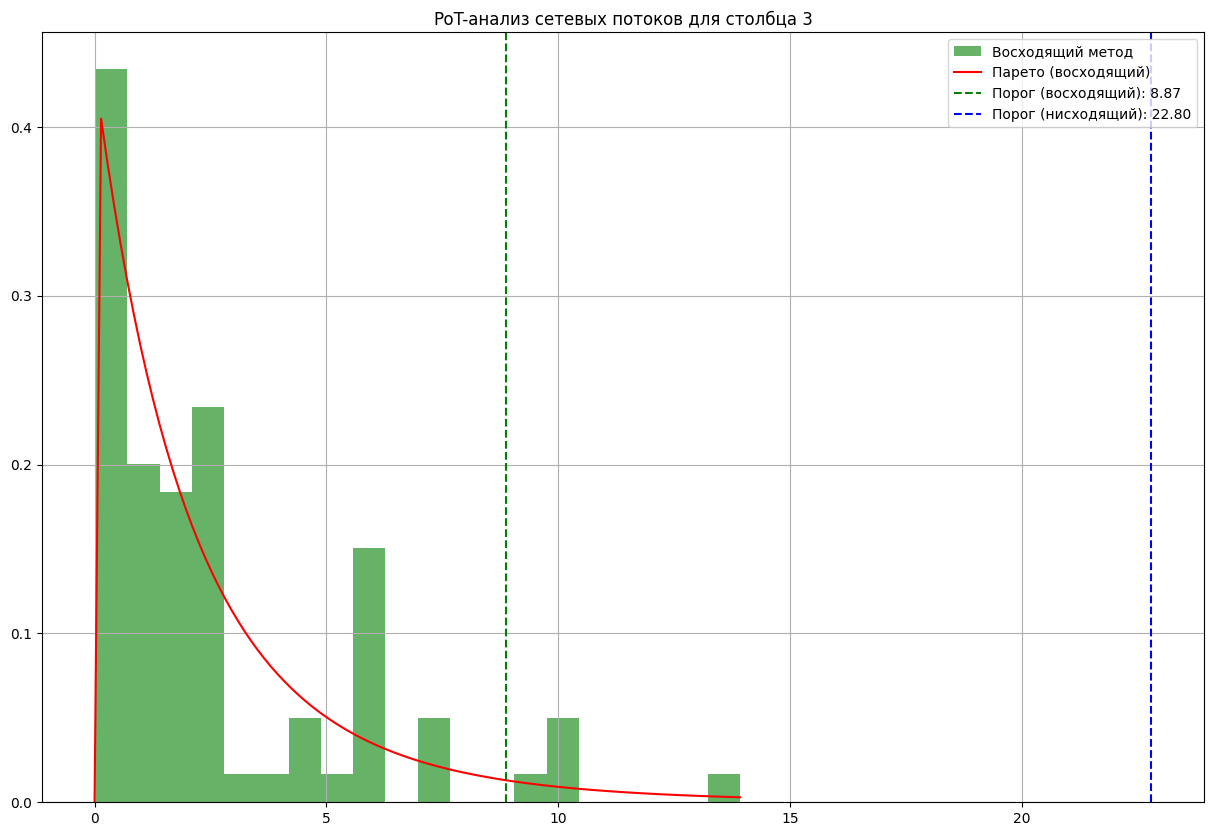

Столбец std_packet_size:
Порог (восходящий): 8.87
Порог (нисходящий): 22.80
p-value для восходящего метода с распределением Парето: 0.24748
p-value для нисходящего метода с распределением Парето: 0.00000

9.915450368846131e-12 0.0


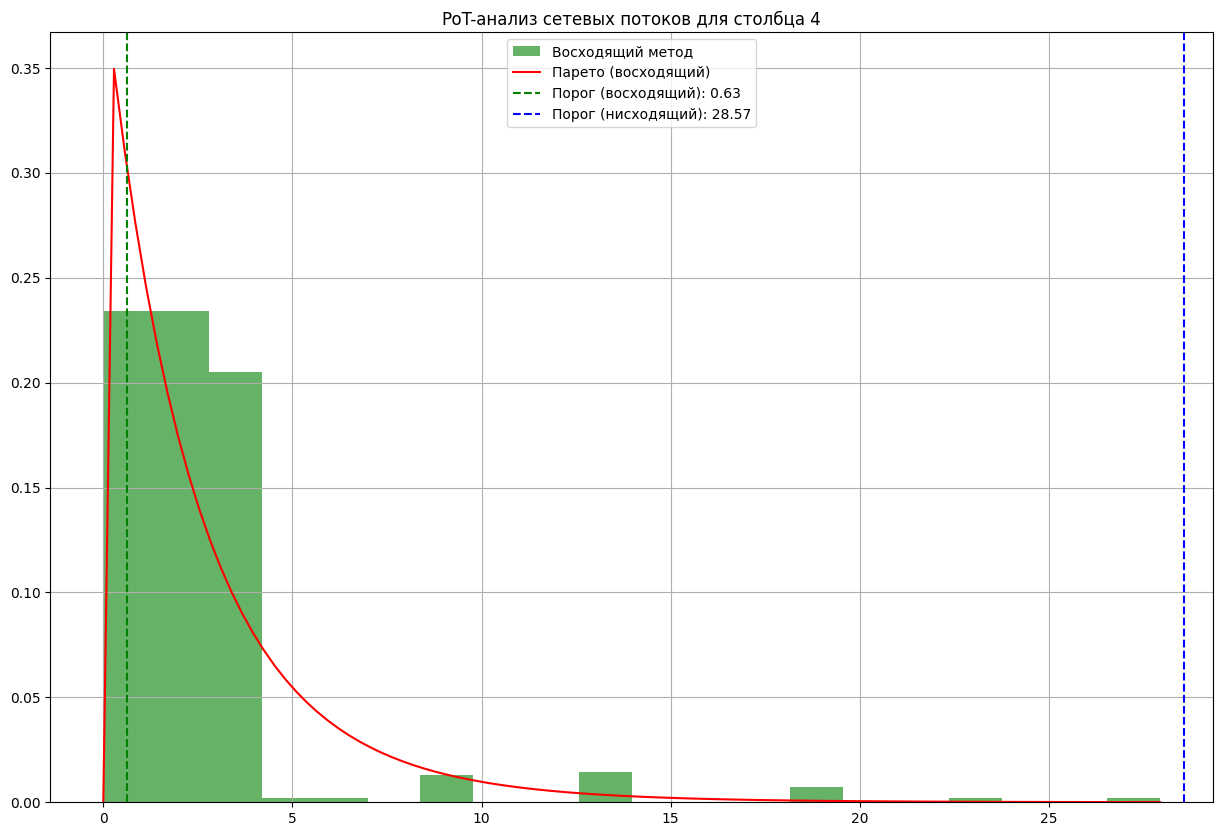

Столбец min_packet_size:
Порог (восходящий): 0.63
Порог (нисходящий): 28.57
p-value для восходящего метода с распределением Парето: 0.00000
p-value для нисходящего метода с распределением Парето: 0.00000

1.648138451376655e-07 0.0


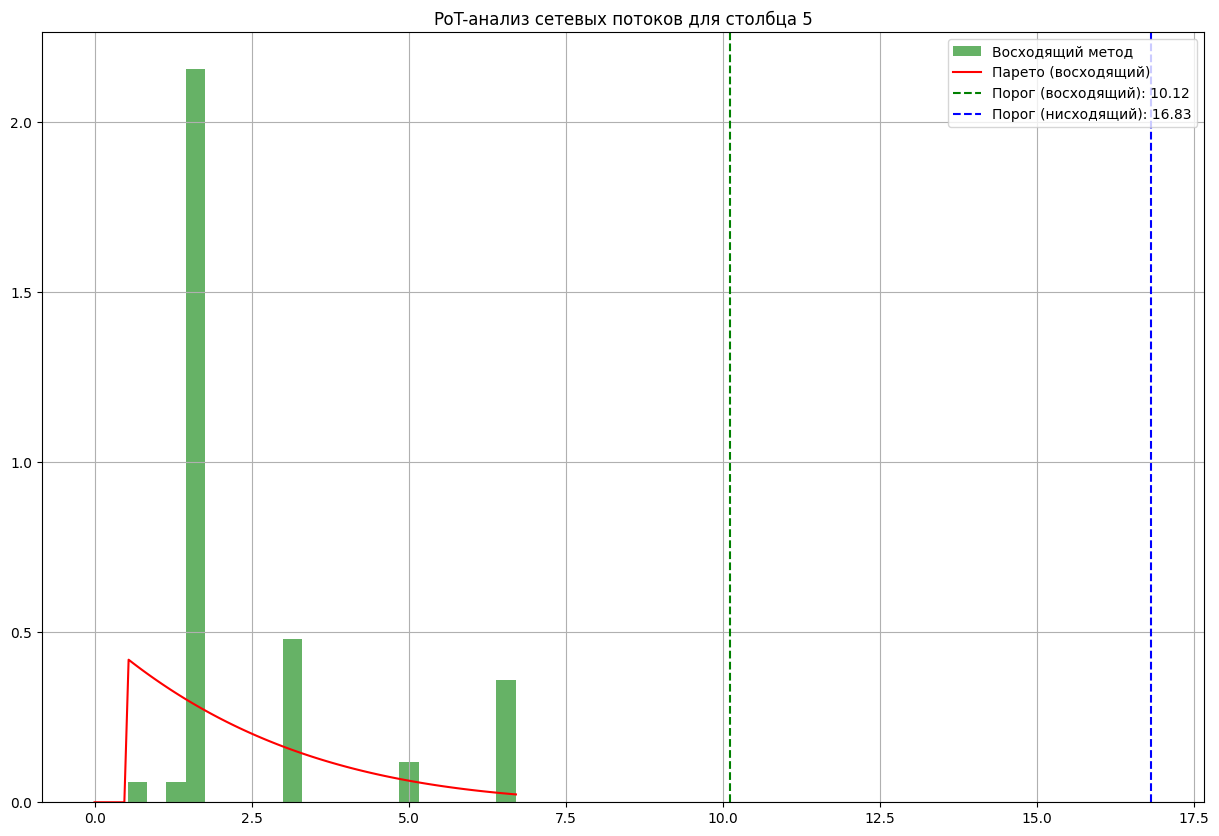

Столбец max_packet_size:
Порог (восходящий): 10.12
Порог (нисходящий): 16.83
p-value для восходящего метода с распределением Парето: 0.00000
p-value для нисходящего метода с распределением Парето: 0.00000



In [ ]:
import numpy as np
from scipy.stats import expon, genpareto, kstest
import matplotlib.pyplot as plt

def pot_analysis(X_res_column, column_index):
    thresholds_up = np.linspace(np.min(X_res_column), np.max(X_res_column), 100)
    p_values_up = []

    for t in thresholds_up:
        excesses = X_res_column[X_res_column > t] - t
        if len(excesses) < 30:
            continue
        loc_up, scale_up = expon.fit(excesses)
        _, p_value = kstest(excesses, 'expon', args=(loc_up, scale_up))
        p_values_up.append(p_value)

    threshold_up = thresholds_up[np.argmax(p_values_up)]

    thresholds_down = np.linspace(np.max(X_res_column), np.min(X_res_column), 100)
    p_values_down = []

    for t in thresholds_down:
        excesses = t - X_res_column[X_res_column < t]
        if len(excesses) < 30:
            continue
        loc_down, scale_down = expon.fit(excesses)
        _, p_value = kstest(excesses, 'expon', args=(loc_down, scale_down))
        p_values_down.append(p_value)

    threshold_down = thresholds_down[np.argmax(p_values_down)]
    print(np.max(p_values_up), np.max(p_values_down))
    excesses_up = X_res_column[X_res_column > threshold_up] - threshold_up
    shape_up, loc_up, scale_up = genpareto.fit(excesses_up)
    _, p_value_up_par = kstest(excesses_up, 'genpareto', args=(shape_up, loc_up, scale_up))

    excesses_down = threshold_down - X_res_column[X_res_column < threshold_down]
    shape_down, loc_down, scale_down = genpareto.fit(excesses_down)
    _, p_value_down_par = kstest(excesses_down, 'genpareto', args=(shape_down, loc_down, scale_down))

    threshold_up_str = f'Порог (восходящий): {threshold_up:.2f}'
    threshold_down_str = f'Порог (нисходящий): {threshold_down:.2f}'
    p_value_up_str = f"p-value для восходящего метода с распределением Парето: {p_value_up_par:.5f}"
    p_value_down_str = f"p-value для нисходящего метода с распределением Парето: {p_value_down_par:.5f}"

    plt.figure(figsize=(15, 10))
    plt.hist(excesses_up, bins=20, alpha=0.6, color='green', density=True, label='Восходящий метод')
    plt.plot(np.linspace(0, max(excesses_up), 100),
             genpareto.pdf(np.linspace(0, max(excesses_up), 100), shape_up, loc_up, scale_up),
             'r-', label='Парето (восходящий)')

    plt.axvline(threshold_up, color='green', linestyle='--', label=threshold_up_str)
    plt.axvline(threshold_down, color='blue', linestyle='--', label=threshold_down_str)

    plt.title(f'PoT-анализ сетевых потоков для столбца {column_index}')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    return threshold_up_str, threshold_down_str, p_value_up_str, p_value_down_str


for i in range(X_res.shape[1]):
    threshold_up_str, threshold_down_str, p_value_up_str, p_value_down_str = pot_analysis(X_res[:, i], i)
    print(f"Столбец {names[i]}:")
    print(threshold_up_str)
    print(threshold_down_str)
    print(p_value_up_str)
    print(p_value_down_str)
    print()


# PoT анализ

In [ ]:
X_analysis = data[['Time', 'Length']].copy()

p_value: [0.]


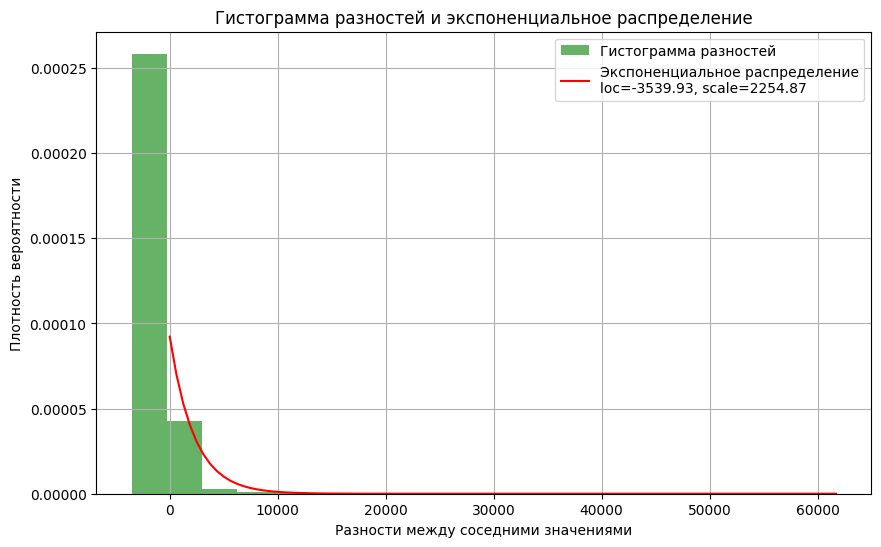

In [ ]:
import numpy as np
from scipy.stats import expon
import matplotlib.pyplot as plt

def plot_exponential_distribution(X):
    time_differences = np.diff(X)

    loc, scale = expon.fit(time_differences)
    _, p_value = kstest(time_differences, 'expon', args=(loc, scale))
    print(f"p_value: {p_value}")
    x_vals = np.linspace(0, np.max(time_differences), 100)
    pdf_vals = expon.pdf(x_vals, loc, scale)

    plt.figure(figsize=(10, 6))
    plt.hist(time_differences, bins=20, alpha=0.6, color='green', density=True, label='Гистограмма разностей')
    plt.plot(x_vals, pdf_vals, 'r-', label=f'Экспоненциальное распределение\nloc={loc:.2f}, scale={scale:.2f}')

    plt.title('Гистограмма разностей и экспоненциальное распределение')
    plt.xlabel('Разности между соседними значениями')
    plt.ylabel('Плотность вероятности')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

plot_exponential_distribution(X_analysis)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import expon, genpareto
from scipy import stats
from tqdm import tqdm
min_count_values = 30
pvalue_max_ascending = 0
pvalue_max_descending = 0
best_threshold_ascending = 0
best_fit_expon = []
def calculate_time_differences(data, threshold):
    exceedances = data[data['Length'] > threshold]
    time_differences = np.diff(exceedances['Time'])
    return time_differences, exceedances

def check_exponential_distribution(time_differences):
    _, p_value = stats.kstest(time_differences, 'expon', args=(time_differences.min(), time_differences.max() - time_differences.min()))
    return p_value

def fit_pareto_distribution(data, threshold):
    exceedances = data[data['Length'] > threshold]['Length'] - threshold
    shape, loc, scale = genpareto.fit(exceedances)
    return shape, loc, scale

def ascending_method(data, min_threshold, max_threshold, step=10):
    global pvalue_max_ascending, best_threshold_ascending, best_fit_expon
    results = []
    for threshold in tqdm(np.arange(min_threshold, max_threshold, step), desc="ascending_method"):
        time_differences, exceedances = calculate_time_differences(data, threshold)
        if len(time_differences) > min_count_values:
            p_value_exp = check_exponential_distribution(time_differences)
            if pvalue_max_ascending < p_value_exp:
                best_threshold_ascending = threshold
                pvalue_max_ascending = p_value_exp
                best_fit_expon = time_differences
            if p_value_exp > 0.05:
                shape, loc, scale = fit_pareto_distribution(exceedances, threshold)
                results.append((threshold, p_value_exp, shape, loc, scale))
    return results

def descending_method(data, max_threshold, min_threshold, step=10):
    global pvalue_max_descending
    results = []
    for threshold in tqdm(np.arange(max_threshold, min_threshold, -step), desc="descending_method"):
        time_differences, exceedances = calculate_time_differences(data, threshold)
        if len(time_differences) > min_count_values:
            p_value_exp = check_exponential_distribution(time_differences)
            pvalue_max_descending = max(pvalue_max_descending, p_value_exp)
            if p_value_exp > 0.05:
                shape, loc, scale = fit_pareto_distribution(exceedances, threshold)
                results.append((threshold, p_value_exp, shape, loc, scale))
    return results

max_threshold = max(X_analysis['Length']) - 1
min_threshold = min(X_analysis['Length'])
n_steps = 100
step = (max_threshold - min_threshold) / n_steps

ascending_results = ascending_method(X_analysis, min_threshold, max_threshold, step=step)
descending_results = descending_method(X_analysis, max_threshold, min_threshold, step=step)
print("Восходящий метод (для анализа сетевого трафика):")
if ascending_results:
    for result in ascending_results:
        print(f"Порог (Размер пакета): {result[0]}, p-value экспоненциального распределения: {result[1]}, Параметры Парето: {result[2:]}")
else:
    print(f"Ни для одного порога не получилось подогнать моменты превышений под экспоненциальное распределение")
    print(f"Максимальный p_value: {pvalue_max_ascending}")

print("\nНисходящий метод (для анализа сетевого трафика):")
if descending_results:
    for result in descending_results:
        print(f"Порог (Размер пакета): {result[0]}, p-value экспоненциального распределения: {result[1]}, Параметры Парето: {result[2:]}")
else:
    print(f"Ни для одного порога не получилось подогнать моменты превышений под экспоненциальное распределение")
    print(f"Максимальный p_value: {pvalue_max_descending}")

# plt.figure(figsize=(12, 6))
# plt.hist(X_analysis['Length'], bins=40, alpha=0.5, label='Размеры пакетов в сети')
# plt.title('Распределение размеров пакетов сетевого трафика')
# plt.xlabel('Размер пакета (байты)')
# plt.ylabel('Частота')
# plt.legend()


# exceedances = X_analysis[X_analysis['Length'] > best_threshold_ascending]
# time_differences = np.diff(exceedances['Time'])
# plt.figure(figsize=(12, 6))
# plt.hist(time_differences, bins=40, alpha=0.5, label='time_differences')
# plt.title('')
# plt.xlabel('')
# plt.ylabel('')
# plt.legend()




# plt.figure(figsize=(12, 6))
# plt.hist(X_analysis[X_analysis['Length'] > best_threshold_ascending]['Length'], bins=40, alpha=0.5, label='time_differences')
# plt.title('График превышений')
# plt.xlabel('')
# plt.ylabel('')
# plt.legend()
# plt.show()
print(f"best_threshold_ascending: {best_threshold_ascending}")

descending_method: 100%|██████████| 100/100 [00:00<00:00, 110.83it/s]

Восходящий метод (для анализа сетевого трафика):
Ни для одного порога не получилось подогнать моменты превышений под экспоненциальное распределение
Максимальный p_value: 1.780544554797448e-38

Нисходящий метод (для анализа сетевого трафика):
Ни для одного порога не получилось подогнать моменты превышений под экспоненциальное распределение
Максимальный p_value: 1.780544554797448e-38
best_threshold_ascending: 43874.44


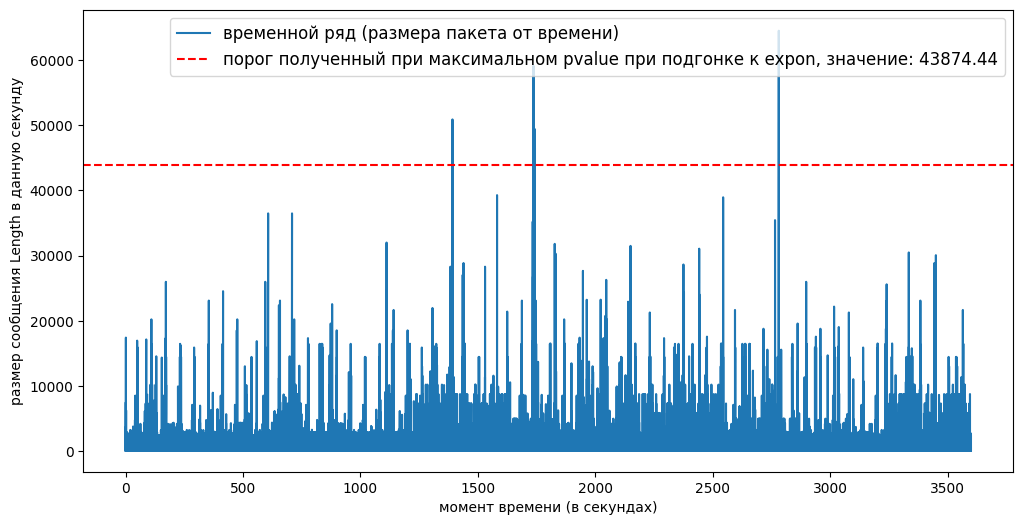

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(X_analysis['Time'], X_analysis['Length'], label='временной ряд (размера пакета от времени)')
plt.xlabel("момент времени (в секундах)")
plt.ylabel("размер сообщения Length в данную секунду")

plt.axhline(y=best_threshold_ascending, color='red', linestyle='--', label=f'порог полученный при максимальном pvalue при подгонке к expon, значение: {best_threshold_ascending}')
plt.legend(fontsize=12)
plt.show()

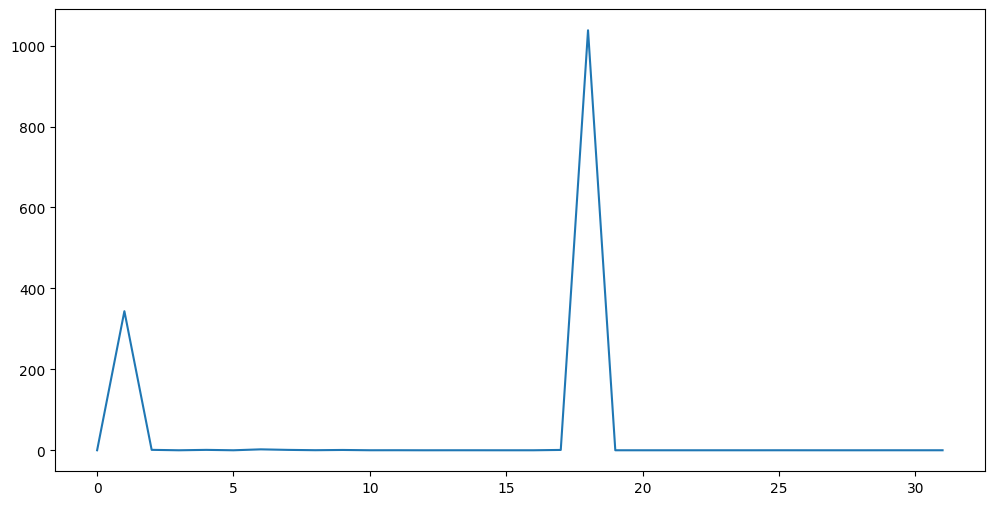

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(best_fit_expon)), best_fit_expon, label="Разность моментов превышения порогового значения")
plt.show()

In [ ]:
pip install distfit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 kB 2.7 MB/s eta 0:00:00


In [ ]:
from scipy.stats import kstest, expon
import matplotlib.pyplot as plt
import numpy as np
from distfit import distfit

class PoT:
    def __init__(self, data):
        self.data = data[["Time", "Length"]].copy()
    def check_expon(self, moments_excess):
        dfit = distfit(distr=['expon'])
        dfit.fit_transform(moments_excess)
        self.params = dfit.model['params']
        D, p_value = kstest(moments_excess, 'expon', args=self.params)
        SSE = dfit.model['score']
        return p_value, SSE, self.params

    def expon_show(self, moments_excess, best_threshold, best_expon_params_asc, yscale=True):
        fig, axes = plt.subplots(ncols = 2, nrows = 1, figsize = (20, 8))
        axes[0].axhline(y=best_threshold, color='red', linestyle='--', label=f'best_threshold: {best_threshold}')
        axes[0].plot(self.data['Time'], self.data["Length"])
        axes[0].set_xlabel("момент времени (сек)")
        axes[0].set_ylabel("Размер пакета")
        axes[0].set_title("Данные")


        # axes[1].hist(moments_excess, density=True, alpha = 0.6, label="Гистограмма моментов превышения", bins=40)
        # x = np.linspace(min(moments_excess), max(moments_excess), 1000)
        # pdf = expon.pdf(x, loc = best_expon_params_asc[0], scale = best_expon_params_asc[1])
        # axes[1].plot(x, pdf, label=f"Экспоненциальное распределение с параметрами loc={best_expon_params_asc[0]}, scale={best_expon_params_asc[1]}")
        # axes[1].set_xlabel("x")
        # axes[1].set_ylabel("y")
        # # axes[1].set_ylim(0.03)
        # axes[1].legend(fontsize=10)
        ax1 = axes[1]
        ax2 = ax1.twinx()  # вторая ось Y

        # Гистограмма
        ax1.hist(moments_excess, bins=40, density=True, alpha=0.6, label="Гистограмма", color="skyblue")
        ax1.set_ylabel("Плотность (гистограмма)", color="skyblue")
        ax1.tick_params(axis='y', labelcolor="skyblue")

        # Кривая PDF
        x = np.linspace(min(moments_excess), max(moments_excess), 1000)
        pdf = expon.pdf(x, loc=best_expon_params_asc[0], scale=best_expon_params_asc[1])
        ax2.plot(x, pdf, color='orangered', label="PDF эксп. распр.", linewidth=2)
        ax2.set_ylabel("Плотность (PDF)", color="orangered")
        ax2.tick_params(axis='y', labelcolor="orangered")
        ax2.set_xlabel("действительная прямая (для отображения expon)")

        ax1.set_xlabel("длина отрезка t_i - t_{i-1}")
        ax1.set_title("PDF и гистограмма разностей моментов превышения")
        if yscale:
            ax1.set_yscale('log')
        plt.show()

    def fit(self, n_thresholds, count_excess=20, yscale = True):
        # ascending_threshold = np.linspace(min(self.data['Length']), max(self.data['Length']), n_thresholds)
        # descending_threshold = np.linspace(max(self.data['Length']), min(self.data['Length']), n_thresholds)
        print(f"Пороги распределены равномерно в отрезке [{min(self.data['Length'])}, {max(self.data['Length'])}], всего порогов - {n_thresholds}")
        max_p_value_asc = 0
        best_threshold_asc = -1
        min_sse_asc = float('inf')
        best_expon_params_asc = []
        # for threshold in ascending_threshold:
        for threshold in range(min(self.data['Length']), max(self.data['Length']), 5):
            excesses = self.data[self.data['Length'] > threshold]
            if len(excesses) > count_excess:
                diff_moments_excess = np.diff(excesses['Time'])
                p_value, sse, params_expon = self.check_expon(diff_moments_excess)

                # if p_value > max_p_value_asc:
                if min_sse_asc > sse:
                    # max_p_value_asc = p_value
                    min_sse_asc = sse
                    best_threshold_asc = threshold
                    best_expon_params_asc = params_expon

        max_p_value_desc = 0
        best_threshold_desc = -1
        min_sse_desc = float('inf')
        best_expon_params_desc = []
        # for threshold in descending_threshold:
        for threshold in range(min(self.data['Length']), max(self.data['Length']), 5):
            excesses = self.data[self.data['Length'] > threshold]
            if len(excesses) > count_excess:
                diff_moments_excess = np.diff(excesses['Time'])
                p_value, sse, params_expon = self.check_expon(diff_moments_excess)
                if min_sse_desc > sse:
                    # max_p_value_desc = p_value
                    min_sse_desc = sse
                    best_threshold_desc = threshold
                    best_expon_params_desc = params_expon
        # print(f"Максимальный p_value полученный в восходящем методе {max_p_value_asc}")
        print(f"Минимальная ошибка при подгонке разностей моментов к expon: {min_sse_asc}")
        print(f"Количество эксцессов { len(self.data[self.data['Length'] > best_threshold_asc]) }")
        # print(f"Максимальный p_value полученный в нисходящем методе {max_p_value_desc}")

        self.expon_show(np.diff(self.data[self.data['Length'] > best_threshold_asc]["Time"]), best_threshold_asc, best_expon_params_asc, yscale)

In [ ]:
model = PoT(data)
count_excess = [20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 50000]
for c_e in count_excess:
    model.fit(n_thresholds = 500, count_excess=c_e, yscale=False)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
model = PoT(data)
count_excess = [20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 50000]
for c_e in count_excess:
    model.fit(n_thresholds = 500, count_excess=c_e, yscale=True)

Output hidden; open in https://colab.research.google.com to view.